In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
import math
from keras.layers import Dense,Input,Conv2D,MaxPooling2D,Dropout,BatchNormalization,Flatten,GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,CSVLogger
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
import keras.backend as K
from keras.utils import to_categorical
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input
from sklearn.metrics import confusion_matrix
import gc
import tqdm
from sklearn.metrics import confusion_matrix,accuracy_score
from keras.preprocessing.image import load_img
from skimage.transform import resize
from skimage.io import imread
from sklearn.metrics import mean_absolute_error



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Using TensorFlow backend.


In [2]:
np.set_printoptions(suppress=True)

PATH = '/kaggle/input/'
TRAIN_PATH = PATH+'distorted_images/'
BATCH_SIZE = 16
lr = 0.001
W,H = 254,254
EPOCH = 25

In [3]:
df = pd.read_csv(PATH+'mos_with_names.txt',sep='\s',header=None,engine='python') 
# Read data details from official page to know the reason
df.rename({0:'Score',1:'Image Name'},axis=1,inplace=True)
df = df[['Image Name','Score']]
df = df.sample(frac=1.0)
df.head()

,Image Name,Score
2916,i25_08_2.bmp,5.05556
1031,i09_15_2.bmp,3.06061
96,i01_20_2.bmp,5.83333
1545,i13_22_1.bmp,5.42857
1656,i14_20_2.bmp,5.59459


In [4]:
df['Score'].nunique()

1457

In [5]:
df['Round Class'] = df['Score'].apply(lambda x: round(x))
df['Ceil Class'] = df['Score'].apply(lambda x: math.ceil(x))
df.describe()

,Score,Round Class,Ceil Class
count,3000.000000,3000.000000,3000.000000
mean,4.474657,4.489667,4.956667
std,1.239880,1.285474,1.272004
min,0.242420,0.000000,1.000000
25%,3.611110,4.000000,4.000000
50%,4.600000,5.000000,5.000000
75%,5.526320,6.000000,6.000000
max,7.214290,7.000000,8.000000


Max score given is 7.2 and minimum is 0.2

In [6]:
y = to_categorical(df['Round Class']) # because mean is close to original and std is close to ceil
# y.shape

In [7]:
df['Label'] = df['Round Class'].apply(lambda x: str(x)) 
#df['Label'] = to_categorical(df['Round Class'])

# because ImageDataGenerator accepts strings as categorical

## Plot Random samples from data

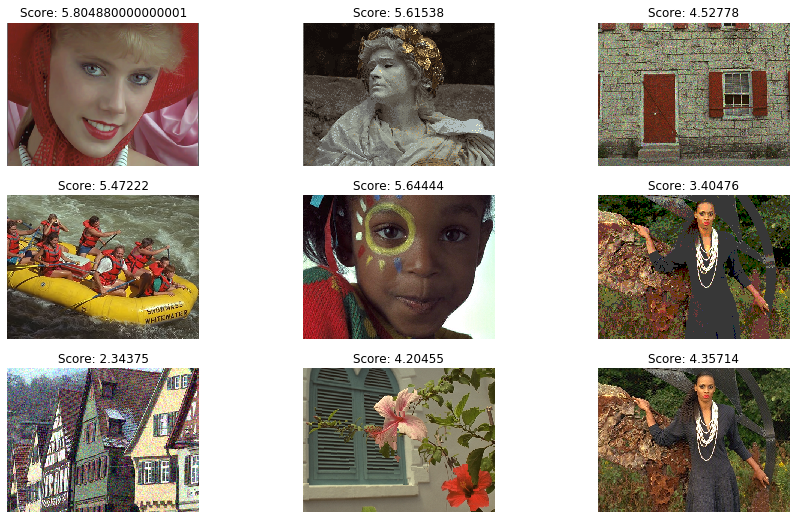

In [8]:
f,ax = plt.subplots(3,3,figsize=(15,9))
ax = ax.ravel()
sample_df = df.sample(9)

for i,index in enumerate(sample_df.index):
    ax[i].imshow(plt.imread(TRAIN_PATH+sample_df.loc[index,'Image Name']))
    ax[i].set_title(f'Score: {sample_df.loc[index,"Score"]}')
    ax[i].axis('off')
    
plt.savefig('random_images.png')


## Images with Minimum and Maximum Scores

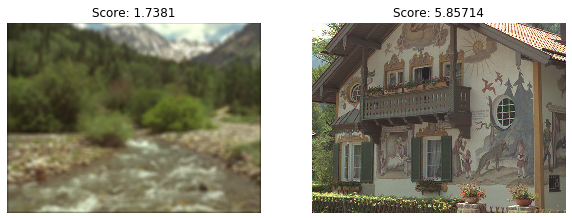

In [9]:
f,ax = plt.subplots(1,2,figsize=(10,5))
ax = ax.ravel()
max_min = [df['Score'].idxmax(),df['Score'].idxmin()]
for i,index in enumerate(max_min):
    ax[i].imshow(plt.imread(TRAIN_PATH+df.iloc[index,0]))
    ax[i].set_title(f'Score: {df.iloc[index,1]}')
    ax[i].axis('off')

plt.savefig('min_max_score_images.png')

## ResNet Transfer Learning

In [10]:
base_model = InceptionResNetV2(input_shape=(W,H, 3),include_top=False,pooling='avg',weights='imagenet')
# Do not train any of the layers so that weights are optimized as they were in imagenet compitition
for layer in base_model.layers: 
    layer.trainable = False

# x = GlobalAveragePooling2D(basemodel.output) # we have used pooling='avg' so no need   
x = Dropout(0.69)(base_model.output)
out = Dense(y.shape[1],activation='softmax')(x)

model = Model(base_model.input,out)

219062272/219055592 [==============================] - 6s 0us/step


In [11]:
optimizer = Adam(lr=0.05) # high lr for burn-in period for the last layer to get used to the weights. 
# Reduce later after hitting pleateau using callback

model.compile(optimizer,loss='categorical_crossentropy',metrics=['acc'])

In [12]:
# model.summary()

In [13]:
es = EarlyStopping(monitor='val_loss',min_delta=0.01,mode='min',patience=8,verbose=1,restore_best_weights=True)

rlp = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1, min_delta=0.01,min_lr=0.0001,
                        mode='min',cooldown=1)

csv_logger = CSVLogger('training.log')

callbacks = [es,rlp,csv_logger]

### Train, validation, test split

In [14]:
split = int(len(df)*0.89)

train_df = df.iloc[:split,:]
test_df = df.iloc[split:,:]


gen=ImageDataGenerator(validation_split=0.11,preprocessing_function=preprocess_input)

train = gen.flow_from_dataframe(train_df,TRAIN_PATH,x_col='Image Name',y_col='Label',subset='training',
                                target_size=(W,H),batch_size=BATCH_SIZE,class_mode='categorical')

val = gen.flow_from_dataframe(train_df,TRAIN_PATH,x_col='Image Name',y_col='Label',subset='validation',
                              target_size=(W,H),batch_size=BATCH_SIZE,class_mode='categorical')

Found 2377 validated image filenames belonging to 8 classes.
Found 293 validated image filenames belonging to 8 classes.


In [15]:
history_inc = model.fit_generator(train,steps_per_epoch=train.n//BATCH_SIZE,epochs=EPOCH,callbacks=callbacks,
                              validation_data=val,validation_steps=val.n//BATCH_SIZE,)

Epoch 1/25
148/148 [==============================] - 40s 270ms/step - loss: 9.7092 - acc: 0.2431 - val_loss: 12.2095 - val_acc: 0.2674
Epoch 2/25
148/148 [==============================] - 20s 138ms/step - loss: 11.9067 - acc: 0.2804 - val_loss: 26.1637 - val_acc: 0.2671
Epoch 3/25
148/148 [==============================] - 20s 134ms/step - loss: 13.7634 - acc: 0.3041 - val_loss: 14.8661 - val_acc: 0.2852
Epoch 4/25
148/148 [==============================] - 20s 134ms/step - loss: 14.1691 - acc: 0.2804 - val_loss: 14.6019 - val_acc: 0.2635

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.015000000223517418.
Epoch 5/25
148/148 [==============================] - 20s 135ms/step - loss: 12.4813 - acc: 0.2965 - val_loss: 14.8585 - val_acc: 0.2744
Epoch 6/25
148/148 [==============================] - 20s 135ms/step - loss: 10.8070 - acc: 0.2965 - val_loss: 13.7962 - val_acc: 0.2888
Epoch 7/25
148/148 [==============================] - 20s 133ms/step - loss: 9.8388 - acc: 0.2910 -

## Predictions

In [16]:
def open_preprocess_image(filepath,W=W,H=H):
    image = imread(filepath)
    image = resize(image,(W,H,3))
    image = preprocess_input(image)
    
    return image


def get_image_batch(test_df):
    images = []
    for i in range(len(test_df)):    
        filepath = TRAIN_PATH+test_df.iloc[i,0]
        image = open_preprocess_image(filepath)
        images.append(image)
        
    return np.array(images)


def get_predictions(images):
    pred_scores = []
    lis = range(y.shape[1])
    
    class_probs = model.predict(images)
    for prob in class_probs:
        score = sum([prob[i]*i for i in lis])
        pred_scores.append(score)
    
    return pred_scores

In [17]:
images = get_image_batch(test_df)
pred_scores = get_predictions(images)
test_df['Pred Score'] = pred_scores
print(f'Model has MAE of: {mean_absolute_error(test_df["Score"],pred_scores)}')

Model has MAE of: 1.0068192102305358


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


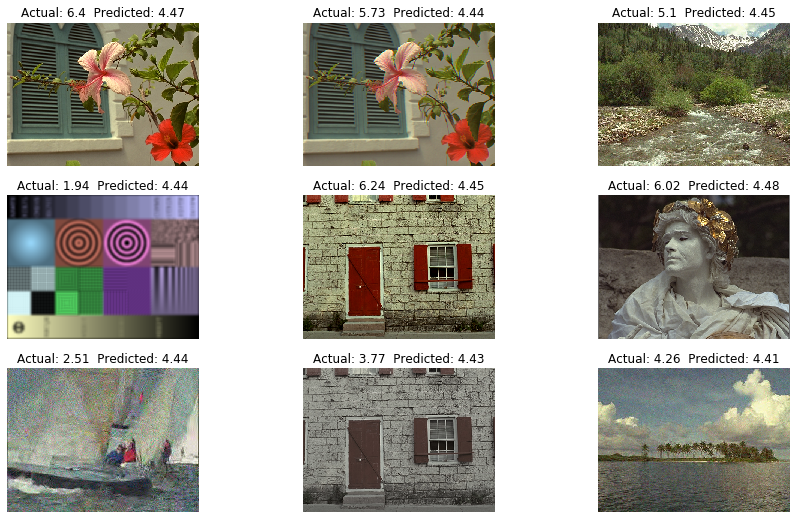

In [18]:
f,ax = plt.subplots(3,3,figsize=(15,9))
ax = ax.ravel()
sample_df = test_df.sample(9)

for i,index in enumerate(sample_df.index):
    ax[i].imshow(plt.imread(TRAIN_PATH+sample_df.loc[index,'Image Name']))
    ax[i].set_title(f'Actual: {round(sample_df.loc[index,"Score"],2)}  Predicted: {round(sample_df.loc[index,"Pred Score"],2)}')
    ax[i].axis('off')
    
plt.savefig('Actual vs Predicted Scores.png')
